# Final Preprocessing using Train.csv and Test.csv

In [1]:
import pandas as p
import numpy as np
import matplotlib.pyplot as plt
import seaborn as s
import pickle

import warnings
warnings.filterwarnings('ignore')

import datetime as dt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

from scipy.stats import shapiro

plt.rcParams['figure.figsize'] = [15,8]

In [7]:
def ReadTrainData(filename) -> p.Series:
    #Reading File
    df_merge = p.read_csv('train.csv')
    df_merge.reset_index(inplace=True)
    '''
    dtype_info = p.DataFrame()
    dtype_info['Unique'] = df_merge.nunique()
    dtype_info['DType'] = df_merge.dtypes
    dtype_info
    '''

    #Conversion Part
    #df_merge.Mileage = df.Mileage.apply(lambda x: float(int(x.split()[0]))/1000)
    df_merge['Mileage'] = p.to_numeric(df_merge.Mileage.str.split(' ').str[0], downcast='float')
    #Mean Part
    df_merge['Mileage'] = np.where(df_merge['Mileage'] == 0.0,df_merge['Mileage'].mean(),df_merge['Mileage'])

    #Fixing Doors
    df_merge['Doors'].unique()
    df_merge.Doors = np.where((df_merge.Doors == '04-May') | (df_merge.Doors == '02-Mar'), df_merge.Doors.str.split('-').str[0],df_merge.Doors)

    #Replacing hyphens with 0s in 'LEVY' column
    def replaceHyphen(n):
        if n == '-':
            return 0.0
        return float(n)
    df_merge.Levy = df_merge.Levy.apply(lambda x: replaceHyphen(x))

    #Getting raw number 
    def convToVol(n):
        n = str(n).strip()
        tokens = n.split()
        return float(tokens[0])
    #Splitting Turbo and non turbo engine types
    def TurboClass(n):
        n = str(n).strip()
        tokens = n.split()
        if len(tokens) == 1:
            return 0
        else:
            return 1
    df_merge['Turbo'] = df_merge['Engine volume'].apply(lambda x: TurboClass(x))
    df_merge['Engine volume'] = df_merge['Engine volume'].apply(lambda x: convToVol(x))
    
    #Calculating age of car
    current = dt.datetime.now()
    df_merge['Prod. year'] = current.year - df_merge['Prod. year']

    return df_merge

In [2]:
def ReadModel(filename) -> int:
    return

# Experimenting with numeric features

<AxesSubplot:xlabel='Levy'>

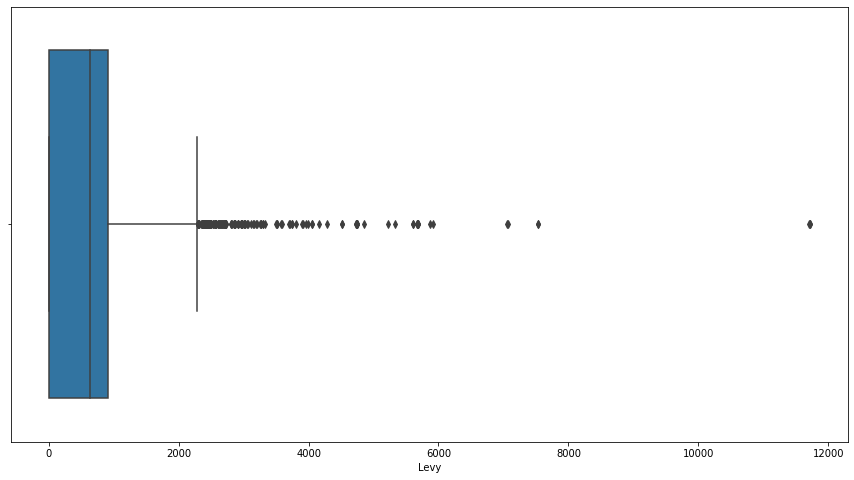

In [11]:
df = ReadTrainData(filename='train.csv')
cols=['Levy','Engine volume', 'Mileage','Cylinders','Airbags']
s.boxplot(df[cols[0]])


<AxesSubplot:xlabel='Engine volume'>

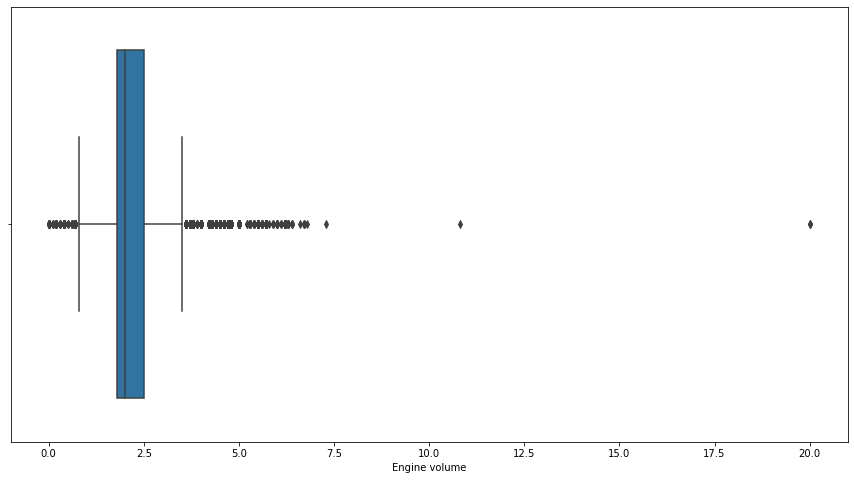

In [12]:
s.boxplot(df[cols[1]])

<AxesSubplot:xlabel='Mileage'>

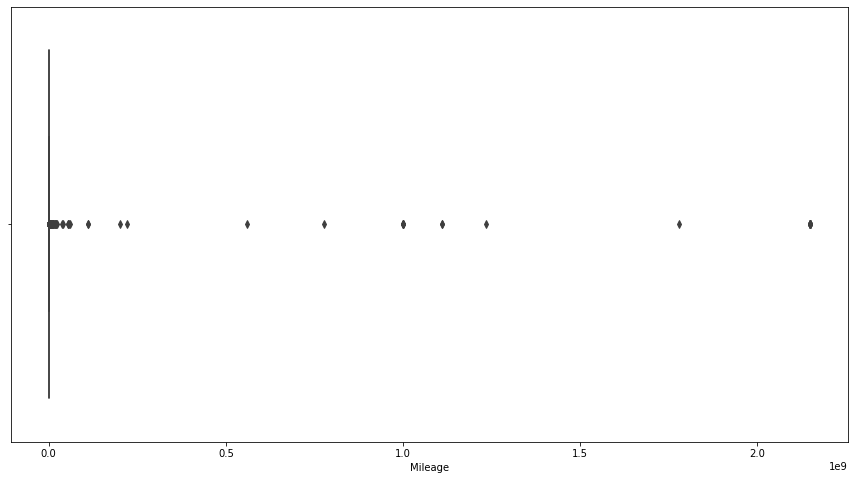

In [13]:
s.boxplot(df[cols[2]])

<AxesSubplot:xlabel='Cylinders'>

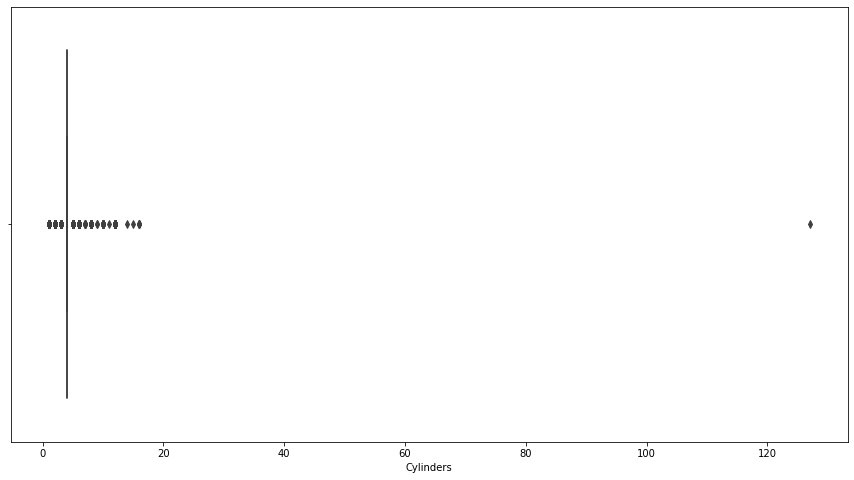

In [14]:
s.boxplot(df[cols[3]])

<AxesSubplot:xlabel='Airbags'>

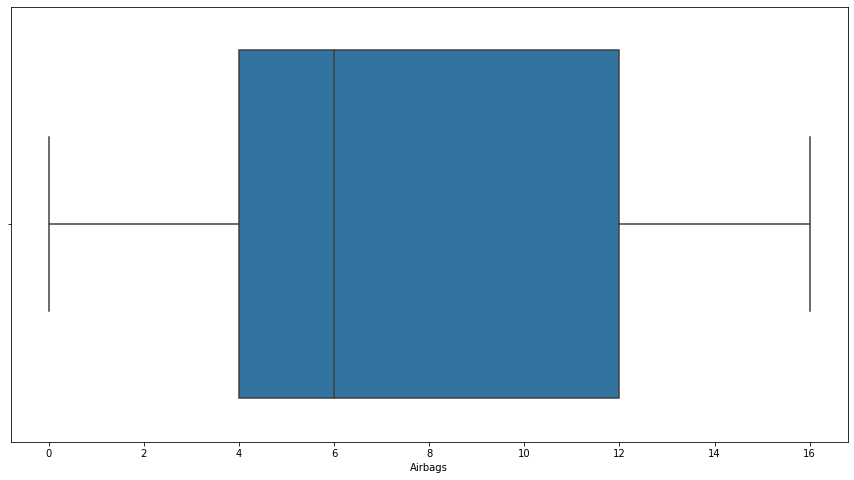

In [15]:
s.boxplot(df[cols[4]])

In [16]:
def FindOutliersLim(column_name, df):
    q1 = np.percentile(df[column_name], 25) #1st quartile - 25%
    q3 = np.percentile(df[column_name], 75) #3rd quartile - 75%
    IQR = q3 - q1 #Inter Quartile Range

    liniency_factor = 1.3
    lim = IQR * liniency_factor
    lower_lim, upper_lim = q1 - lim, q3 + lim
    return lower_lim, upper_lim
def RemoveOutlier(df, column_name, upper_lim, lower_lim):
    outlier_list = [x for x in df[column_name] if x < upper_lim]
    